# Making Structural Estimates From Empirical Results

This notebook conducts a quick and dirty structural estimation based on Table 9 of "MPC Heterogeneity and Household Balance Sheets" by Fagereng, Holm, and Natvik <cite data-cite="6202365/SUE56C4B"></cite>, who use Norweigian administrative data on income, household assets, and lottery winnings to examine the MPC from transitory income shocks (lottery prizes).  Their Table 9 reports an estimated MPC broken down by quartiles of bank deposits and
prize size; this table is reproduced here as $\texttt{MPC_target_base}$.  In this demo, we use the Table 9 estimates as targets in a simple structural estimation, seeking to minimize the sum of squared differences between simulated and estimated MPCs by changing the (uniform) distribution of discount factors.  The essential question is how well their results be rationalized by a simple one-asset consumption-saving model.  


The function that estimates discount factors includes several options for estimating different specifications:

1. TypeCount : Integer number of discount factors in discrete distribution; can be set to 1 to turn off _ex ante_ heterogeneity (and to discover that the model has no chance to fit the data well without such heterogeneity).
2. AdjFactor : Scaling factor for the target MPCs; user can try to fit estimated MPCs scaled down by (e.g.) 50%.
3. T_kill    : Maximum number of years the (perpetually young) agents are allowed to live.  Because this is quick and dirty, it's also the number of periods to simulate.
4. Splurge   : Amount of lottery prize that an individual will automatically spend in a moment of excitement (perhaps ancient tradition in Norway requires a big party when you win the lottery), before beginning to behave according to the optimal consumption function.  The patterns in Table 9 can be fit much better when this is set around \$700 --> 0.7.  That doesn't seem like an unreasonable amount of money to spend on a memorable party.
5. do_secant : Boolean indicator for whether to use "secant MPC", which is average MPC over the range of the prize.  MNW believes authors' regressions are estimating this rather than point MPC.  When False, structural estimation uses point MPC after receiving prize.  NB: This is incompatible with Splurge > 0.
6. drop_corner : Boolean for whether to include target MPC in the top left corner, which is greater than 1.  Authors discuss reasons why the MPC from a transitory shock *could* exceed 1.  Option is included here because this target tends to push the estimate around a bit.

In [1]:
# Import python tools

import sys
import os

import numpy as np
from copy import deepcopy

In [2]:
# Import needed tools from HARK

from HARK.utilities import approxUniform, getPercentiles
from HARK.parallel import multiThreadCommands
from HARK.estimation import minimizeNelderMead
from HARK.ConsumptionSaving.ConsIndShockModel import *
from HARK.cstwMPC.SetupParamsCSTW import init_infinite

In [3]:
# Set key problem-specific parameters

TypeCount = 8    # Number of consumer types with heterogeneous discount factors
AdjFactor = 1.0  # Factor by which to scale all of MPCs in Table 9
T_kill = 100     # Don't let agents live past this age
Splurge = 0.7    # Consumers automatically spend this amount of any lottery prize
do_secant = True # If True, calculate MPC by secant, else point MPC
drop_corner = True # If True, ignore upper left corner when calculating distance

In [4]:
# Set standard HARK parameter values

base_params = deepcopy(init_infinite)
base_params['LivPrb'] = [0.975]
base_params['Rfree'] = 1.04/base_params['LivPrb'][0]
base_params['PermShkStd'] = [0.1]
base_params['TranShkStd'] = [0.1]
base_params['T_age'] = T_kill # Kill off agents if they manage to achieve T_kill working years
base_params['AgentCount'] = 10000
base_params['pLvlInitMean'] = np.log(23.72) # From Table 1, in thousands of USD
base_params['T_sim'] = T_kill  # No point simulating past when agents would be killed off

In [5]:
# Define the MPC targets from Fagereng et al Table 9; element i,j is lottery quartile i, deposit quartile j

MPC_target_base = np.array([[1.047, 0.745, 0.720, 0.490],
                            [0.762, 0.640, 0.559, 0.437],
                            [0.663, 0.546, 0.390, 0.386],
                            [0.354, 0.325, 0.242, 0.216]])
MPC_target = AdjFactor*MPC_target_base

In [6]:
# Define the four lottery sizes, in thousands of USD; these are eyeballed centers/averages

lottery_size = np.array([1.625, 3.3741, 7.129, 40.0])

In [7]:
# Make several consumer types to be used during estimation

BaseType = IndShockConsumerType(**base_params)
EstTypeList = []
for j in range(TypeCount):
    EstTypeList.append(deepcopy(BaseType))
    EstTypeList[-1](seed = j)

In [8]:
# Define the objective function

def FagerengObjFunc(center,spread,verbose=False):
    '''
    Objective function for the quick and dirty structural estimation to fit
    Fagereng, Holm, and Natvik's Table 9 results with a basic infinite horizon
    consumption-saving model (with permanent and transitory income shocks).

    Parameters
    ----------
    center : float
        Center of the uniform distribution of discount factors.
    spread : float
        Width of the uniform distribution of discount factors.
    verbose : bool
        When True, print to screen MPC table for these parameters.  When False,
        print (center, spread, distance).

    Returns
    -------
    distance : float
        Euclidean distance between simulated MPCs and (adjusted) Table 9 MPCs.
    '''
    # Give our consumer types the requested discount factor distribution
    beta_set = approxUniform(N=TypeCount,bot=center-spread,top=center+spread)[1]
    for j in range(TypeCount):
        EstTypeList[j](DiscFac = beta_set[j])

    # Solve and simulate all consumer types, then gather their wealth levels
    multiThreadCommands(EstTypeList,['solve()','initializeSim()','simulate(95)','unpackcFunc()'])
    WealthNow = np.concatenate([ThisType.aLvlNow for ThisType in EstTypeList])

    # Get wealth quartile cutoffs and distribute them to each consumer type
    quartile_cuts = getPercentiles(WealthNow,percentiles=[0.25,0.50,0.75])
    for ThisType in EstTypeList:
        WealthQ = np.zeros(ThisType.AgentCount,dtype=int)
        for n in range(3):
            WealthQ[ThisType.aLvlNow > quartile_cuts[n]] += 1
        ThisType(WealthQ = WealthQ)

    # Keep track of MPC sets in lists of lists of arrays
    MPC_set_list = [ [[],[],[],[]],
                     [[],[],[],[]],
                     [[],[],[],[]],
                     [[],[],[],[]] ]

    # Calculate the MPC for each of the four lottery sizes for all agents
    for ThisType in EstTypeList:
        ThisType.simulate(1)
        c_base = ThisType.cNrmNow
        MPC_this_type = np.zeros((ThisType.AgentCount,4))
        for k in range(4): # Get MPC for all agents of this type
            Llvl = lottery_size[k]
            Lnrm = Llvl/ThisType.pLvlNow
            if do_secant:
                SplurgeNrm = Splurge/ThisType.pLvlNow
                mAdj = ThisType.mNrmNow + Lnrm - SplurgeNrm
                cAdj = ThisType.cFunc[0](mAdj) + SplurgeNrm
                MPC_this_type[:,k] = (cAdj - c_base)/Lnrm
            else:
                mAdj = ThisType.mNrmNow + Lnrm
                MPC_this_type[:,k] = cAdj = ThisType.cFunc[0].derivative(mAdj)

        # Sort the MPCs into the proper MPC sets
        for q in range(4):
            these = ThisType.WealthQ == q
            for k in range(4):
                MPC_set_list[k][q].append(MPC_this_type[these,k])

    # Calculate average within each MPC set
    simulated_MPC_means = np.zeros((4,4))
    for k in range(4):
        for q in range(4):
            MPC_array = np.concatenate(MPC_set_list[k][q])
            simulated_MPC_means[k,q] = np.mean(MPC_array)

    # Calculate Euclidean distance between simulated MPC averages and Table 9 targets
    diff = simulated_MPC_means - MPC_target
    if drop_corner:
        diff[0,0] = 0.0
    distance = np.sqrt(np.sum((diff)**2))
    if verbose:
        print(simulated_MPC_means)
    else:
        print (center, spread, distance)
    return distance

In [9]:
# Conduct the estimation

guess = [0.92,0.03]
guess = [0.78981881,0.16098057]
f_temp = lambda x : FagerengObjFunc(x[0],x[1])
opt_params = minimizeNelderMead(f_temp, guess, verbose=True)
print('Finished estimating for scaling factor of ' + str(AdjFactor) + ' and "splurge amount" of $' + str(1000*Splurge))
print('Optimal (beta,nabla) is ' + str(opt_params) + ', simulated MPCs are:')
dist = FagerengObjFunc(opt_params[0],opt_params[1],True)
print('Distance from Fagereng et al Table 9 is ' + str(dist))

0.78981881 0.16098057 0.48580048893979316
0.8293097505 0.16098057 0.3313405262934448
0.78981881 0.1690295985 0.47856230067166305
0.8293097505000001 0.1690295985 0.34477770781230793
0.868800691 0.16098057 0.3919051119568574
0.84905522075 0.162992827125 0.34766503675642896
0.80956428025 0.167017341375 0.39059276121654307
0.839182485625 0.1639989556875 0.33006777250767005
0.839182485625 0.1559499271875 0.3114573947400921
0.8441188531874999 0.14941009153125 0.29759656997602174
0.8539915883125 0.15242847721875002 0.32272265417221446
0.8589279558749999 0.13783961306250003 0.2896970383427969
0.8688006909999999 0.12475994175000005 0.28538450938568033
0.8589279558749998 0.12174155606250003 0.2552805685429768
0.8613961396562497 0.10639809548437507 0.23895645235891916
0.8860779774687497 0.0817479457031251 0.27842013631444334
0.8786734261249995 0.06338609943750012 0.29913161682865297
0.8712688747812498 0.10941648117187507 0.25837997054375333
0.8465870369687498 0.13406663095312504 0.272324605815368

### PROBLEM

See what happens if you do not allow a splurge amount at all.  Hint: Think about how this question relates to the `drop_corner` option.

Explain why you get the results you do, and comment on possible interpretations of the "splurge" that might be consistent with economic theory.    
Hint: What the authors are able to measure is actually the marginal propensity to EXPEND, not the marginal propensity to CONSUME as it is defined in our benchmark model.

MPC distribution for `splurge=0.7` and `drop_corner=0` is  
0.78058645 0.74852543 0.69758672  0.57062401  
0.68077668 0.64027802 0.57082729  0.39800477  
0.60892177 0.5696061 0.4929874   0.30577941  
0.43708697 0.40971915 0.34376774  0.1947101  
Estimation: beta-point =0.86, nabla =12   
The distance is 0.36  
The estimator choses a relatively low beta and high nabla when `drop_corner` is set to zero. This is because it puts high importance on matching the MPC value in the upper left corner of the target matrix as the distance to the target is large. The low beta, however, deteriorates matches with the MPC target in other lottery / wealth quartiles. 


MPC distribution for `splurge=0.7` and `drop_corner=1` is  
0.76146837 0.73294988 0.68867587 0.58023753  
0.65406631 0.61881131 0.55855225 0.41047637  
0.5784164  0.54533118 0.47933813 0.31933032  
0.4037176  0.38408734 0.33105934 0.20577312   
Estimation: beta-point = 0.87, nabla = 0.10  
The distance is 0.24  
With `drop_corner` switched on, the distance is lower. This happens (i) mechanically since one difference is excluded from the euclidean distance, but also (ii) because the now higher beta-point value, allows to match other MPC targets of lower values much easier. The point estimate of beta-point is higher, the nabla becomes smaller, another indicator that the model does a better job to replicate the data as it needs less ex-ante heterogeneity. 


MPC distribution for `splurge=0.0` and `drop_corner=0` is  
0.77363444 0.68301477 0.56440589 0.40411035  
0.74357098 0.66467557 0.55281926 0.39561326  
0.70355573 0.6349713  0.53035817 0.37868694  
0.56134351 0.5041643  0.41242587 0.29210923    
Estimation: beta-point = 0.79, nabla = 0.16  
The distance is 0.50.  
With both options set to zero, we obtain the worst fit. This indicates that removing the splurge makes it more difficult for the model to match the relative high MPC for lower wealth quartiles. This is compensated by a lower beta-point estimate. However, this goes at the cost of other, lower values of the MPC targets. 



### PROBLEM

Call the _Marginal Propensity to Continue Consuming_ (MPCC) in year `t+n` the proportion of lottery winnings that get spent in year `t+n`.  That is, if consumption is higher in year `t+2` by an amount corresponding to 14 percent of lottery winnings, we would say  _the MPCC in t+2 is 14 percent.

For the baseline version of the model with the "splurge" component, calculate the MPCC's for years `t+1` through `t+3` and plot them together with the MPC in the first year (including the splurge component)


The MPC for t+0 is 
 [[0.7634 0.7354 0.6895 0.5821]
 [0.6557 0.622  0.56   0.414 ]
 [0.5784 0.5483 0.4813 0.3243]
 [0.4026 0.3868 0.3344 0.2149]]


The MPCC for t+1 is 
 [[0.1612 0.18   0.2003 0.2072]
 [0.2115 0.2229 0.2292 0.1974]
 [0.2413 0.2464 0.2431 0.1906]
 [0.2601 0.2583 0.2373 0.1682]]


The MPCC for t+2 is 
 [[0.0928 0.1189 0.1637 0.2392]
 [0.1083 0.1269 0.157  0.1879]
 [0.1242 0.1367 0.1576 0.1631]
 [0.17   0.1722 0.1721 0.1409]]


The MPCC for t+3 is 
 [[0.0656 0.0891 0.1396 0.2666]
 [0.0627 0.0793 0.1144 0.184 ]
 [0.0674 0.0792 0.1061 0.1446]
 [0.1069 0.1107 0.1225 0.119 ]]

 I plot as an example the evolution of the MPC in the 2nd quartile of wealth and lottery win.


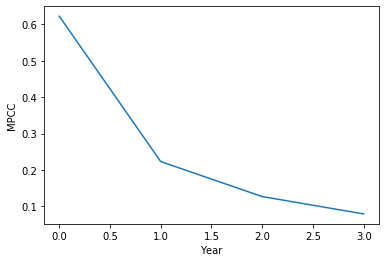

In [15]:
def FagerengFutureObjFunc(center,spread,verbose=False):

    # Give our consumer types the requested discount factor distribution
    beta_set = approxUniform(N=TypeCount,bot=center-spread,top=center+spread)[1]
    for j in range(TypeCount):
        EstTypeList[j](DiscFac = beta_set[j])
        # add tracking vars to each Type
        EstTypeList[j].track_vars = ['aNrmNow','mNrmNow','cNrmNow','pLvlNow','PermShkNow','TranShkNow']

    # Solve and simulate all consumer types, then gather their wealth levels
    StartPeriod = 95;
    multiThreadCommands(EstTypeList,['solve()','initializeSim()','simulate(95)','unpackcFunc()'])
    WealthNow = np.concatenate([ThisType.aLvlNow for ThisType in EstTypeList])

    # Get wealth quartile cutoffs and distribute them to each consumer type
    quartile_cuts = getPercentiles(WealthNow,percentiles=[0.25,0.50,0.75])
    for ThisType in EstTypeList:
        WealthQ = np.zeros(ThisType.AgentCount,dtype=int)
        for n in range(3):
            WealthQ[ThisType.aLvlNow > quartile_cuts[n]] += 1
        ThisType(WealthQ = WealthQ)

    # Keep track of MPC sets in lists of lists of arrays
    MPC_set_list = [ [[],[],[],[]],
                     [[],[],[],[]],
                     [[],[],[],[]],
                     [[],[],[],[]] ]
    MPC_set_list_t1 = deepcopy(MPC_set_list)
    MPC_set_list_t2 = deepcopy(MPC_set_list)
    MPC_set_list_t3 = deepcopy(MPC_set_list)

    Rfree = base_params['Rfree']
    # Calculate the MPC for each of the four lottery sizes for all agents
    for ThisType in EstTypeList:
        ThisType.simulate(4)
        c_base_0 = ThisType.cNrmNow_hist[StartPeriod]
        c_base_t1 = ThisType.cNrmNow_hist[StartPeriod+1]
        c_base_t2 = ThisType.cNrmNow_hist[StartPeriod+2]
        c_base_t3 = ThisType.cNrmNow_hist[StartPeriod+3]
        
        MPC_this_type = np.zeros((ThisType.AgentCount,4))
        MPC_this_type_t1 = np.zeros((ThisType.AgentCount,4))
        MPC_this_type_t2 = np.zeros((ThisType.AgentCount,4))
        MPC_this_type_t3 = np.zeros((ThisType.AgentCount,4))
    
        for k in range(4): # Get MPC for all agents of this type       
            Llvl = lottery_size[k]
            Lnrm = Llvl/ThisType.pLvlNow_hist[StartPeriod]     
            SplurgeNrm = Splurge/ThisType.pLvlNow_hist[StartPeriod]
            mAdj = ThisType.mNrmNow_hist[StartPeriod] + Lnrm - SplurgeNrm
            cAdj = ThisType.cFunc[0](mAdj) + SplurgeNrm
            MPC_this_type[:,k] = (cAdj - c_base_0) /Lnrm
            
            # Calculate normalized market resources in t+1 (varnames t1)
            #Llvl = lottery_size[k]
            Lnrm = Llvl/ThisType.pLvlNow_hist[StartPeriod+1]
            aNrm_t0 = ThisType.mNrmNow_hist[StartPeriod] + Lnrm - cAdj
            aLvl_t0 = aNrm_t0*ThisType.pLvlNow_hist[StartPeriod]
            mLvl_t1 = aLvl_t0*Rfree + ThisType.TranShkNow_hist[StartPeriod+1]*ThisType.pLvlNow_hist[StartPeriod+1]
            mNrm_t1 = mLvl_t1/ThisType.pLvlNow_hist[StartPeriod+1]
            cNrm_t1 = ThisType.cFunc[0](mNrm_t1)
            MPC_this_type_t1[:,k] = (cNrm_t1 - c_base_t1) /Lnrm

            # Calculate normalized market resources in t+2 (varnames t2)
            Llvl = lottery_size[k]
            Lnrm = Llvl/ThisType.pLvlNow_hist[StartPeriod+2]
            aNrm_t1 = mNrm_t1 - cNrm_t1;
            aLvl_t1 = aNrm_t1*ThisType.pLvlNow_hist[StartPeriod+1]
            mLvl_t2 = aLvl_t1*Rfree + ThisType.TranShkNow_hist[StartPeriod+2]*ThisType.pLvlNow_hist[StartPeriod+2]
            mNrm_t2 = mLvl_t2/ThisType.pLvlNow_hist[StartPeriod+2]
            cNrm_t2 = ThisType.cFunc[0](mNrm_t2)
            MPC_this_type_t2[:,k] = (cNrm_t2 - c_base_t2) /Lnrm

            # Calculate normalized market resources in t+3 (varnames t3)
            Llvl = lottery_size[k]
            Lnrm = Llvl/ThisType.pLvlNow_hist[StartPeriod+3]
            aNrm_t2 = mNrm_t2 - cNrm_t2;
            aLvl_t2 = aNrm_t2*ThisType.pLvlNow_hist[StartPeriod+2]
            mLvl_t3 = aLvl_t2*Rfree + ThisType.TranShkNow_hist[StartPeriod+3]*ThisType.pLvlNow_hist[StartPeriod+3]
            mNrm_t3 = mLvl_t3/ThisType.pLvlNow_hist[StartPeriod+3]
            cNrm_t3 = ThisType.cFunc[0](mNrm_t3)
            MPC_this_type_t3[:,k] = (cNrm_t3 - c_base_t3) /Lnrm
            

        # Sort the MPCs into the proper MPC sets
        for q in range(4):
            these = ThisType.WealthQ == q
            for k in range(4):
                MPC_set_list[k][q].append(MPC_this_type[these,k])
                MPC_set_list_t1[k][q].append(MPC_this_type_t1[these,k])
                MPC_set_list_t2[k][q].append(MPC_this_type_t2[these,k])
                MPC_set_list_t3[k][q].append(MPC_this_type_t3[these,k])

    # Calculate average within each MPC set
    simulated_MPC_means = np.zeros((4,4))
    simulated_MPC_means_t1 = np.zeros((4,4))
    simulated_MPC_means_t2 = np.zeros((4,4))
    simulated_MPC_means_t3 = np.zeros((4,4))
    for k in range(4):
        for q in range(4):
            MPC_array = np.concatenate(MPC_set_list[k][q])
            simulated_MPC_means[k,q] = np.mean(MPC_array)
            simulated_MPC_means_t1[k,q] = np.mean(np.concatenate(MPC_set_list_t1[k][q]))
            simulated_MPC_means_t2[k,q] = np.mean(np.concatenate(MPC_set_list_t2[k][q]))
            simulated_MPC_means_t3[k,q] = np.mean(np.concatenate(MPC_set_list_t3[k][q]))
            
    print('The MPC for t+0 is \n', np.round(simulated_MPC_means,4))
    print('\n')
    print('The MPCC for t+1 is \n', np.round(simulated_MPC_means_t1,4))
    print('\n')
    print('The MPCC for t+2 is \n', np.round(simulated_MPC_means_t2,4))
    print('\n')
    print('The MPCC for t+3 is \n', np.round(simulated_MPC_means_t3,4))
    
    
    import matplotlib.pyplot as plt
    print('\n I plot as an example the evolution of the MPC in the 2nd quartile of wealth and lottery win.')
    plt.plot([0, 1, 2, 3],[simulated_MPC_means[1,1],simulated_MPC_means_t1[1,1],simulated_MPC_means_t2[1,1],simulated_MPC_means_t3[1,1]])
    plt.xlabel('Year')
    plt.ylabel('MPCC')
    plt.show(block=False)

    # Calculate Euclidean distance between simulated MPC averages and Table 9 targets
    diff = simulated_MPC_means - MPC_target
    if drop_corner:
        diff[0,0] = 0.0
    distance = np.sqrt(np.sum((diff)**2))
    return distance

dist = FagerengFutureObjFunc(opt_params[0],opt_params[1],True)